In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


In [2]:
from configs.seq_fd_gru import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'prodn'), ('in_seq_len', 168), ('input_channels', 1), ('input_dim', 5), ('lambd', 1e-06), ('learning_rate', 0.001), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


In [3]:
hparams=tf.contrib.training.HParams(
        batch_size=800,
        in_seq_len=5 * 24 + 1,
        input_dim=1,
        input_channels=1,
        out_seq_len=24,
        output_dim=1,
        output_channels=1,
        num_layers=1,
        neurons_unit=32,
        learning_rate = 10 ** -2.5,
        lr_decay = 0.99,
        lambd = 0,
        train_split = 0.8,
        val_split = 0.1,
        test_split = 0.1,
        norm_epsilon = 1e-12,
        datagen = 'biogas',
        logs_path = '/tmp/tensorflow_logs')

In [4]:
from data_loader.biogas import *
get_fields = 'AT305'
hparams.in_seq_len = 5 * 24 + 12
hparams.input_dim = 1
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields, normalise='local_max')
hparams.in_seq_len = 24
hparams.input_dim = 5
inp, target, mask, x_max = next(iter(dataset))

In [5]:
class pAttention(tf.keras.Model):
    def __init__(self, mode='var', epsilon = 1e-12):
        super(pAttention, self).__init__()
        self.W1 = tf.Variable(2., name='W_separation')
        self.W2 = tf.Variable(1., name='W_scale')
        self.W3 = tf.Variable(0., name='W_recency')
        self.epsilon = epsilon
        self.w  = None

        if mode == 'var':
            self.variance = self.norm_var
        else:
            self.variance = self.norm_cov

    def cov(self, x):
        """
        Calculate covariance between channels
        """
        n_dim  = tf.cast(tf.shape(x)[1], tf.float32) - 1
        mu_x   = x - tf.reduce_mean(x, axis=1, keep_dims=True)
        cov_xx = tf.matmul(mu_x, mu_x, transpose_a=True) / n_dim
        
        return cov_xx

    def norm_cov(self, x):
        context = self.cov(x)
        
        context     = tf.reduce_sum(context, axis=1)
        context_max = tf.reduce_max(context, axis=1, keep_dims=True)
        
        return context / (context_max + self.epsilon)

    def var(self, x):
        """
        Calculate variance on difference between channels
        """
        xx = tf.expand_dims(x, axis=-1)
        xx = xx - tf.transpose(xx, [0,1,3,2])
        mu_xx, var_xx = tf.nn.moments(xx, [1])
        
        return var_xx
        
    def norm_var(self, x):
        n_dim  = tf.cast(tf.shape(x)[-1], tf.float32)
        recency = tf.exp(self.W3 * tf.range(n_dim))
        recency = tf.expand_dims(recency, 0)
        
        context = self.var(x) * recency
        
        context     = tf.reduce_sum(context, axis=1)
        context_max = tf.reduce_max(context, axis=1, keep_dims=True)
        
        return (context_max - context) / (context_max + self.epsilon)
        
    def call(self, x, hidden):

        context = self.variance(x)
        
        score   = tf.exp(self.W1) * context
        weights = tf.nn.softmax(score, axis=1)
        weights = tf.expand_dims(weights, axis=1)
        self.w  = weights
        
        outputs = self.W2 * tf.reduce_mean(weights * tf.squeeze(hidden), axis=-1, keepdims=True) 
        
        return outputs

In [6]:
class pAttentionBias(pAttention):
    """
    pAttention model with learnable bias term for model score calculation
    Allows model to learn weights related to recency
    """
    def __init__(self, input_dim, mode='var'):
        super(pAttentionBias, self).__init__()
        # Initialise bias term
        self.b1 = tf.Variable(tf.zeros([input_dim]))
    
    def call(self, x, hidden):
        context = self.variance(x)
        
        score   = tf.exp(self.W1) * context * self.b1
        weights = tf.nn.softmax(score, axis=1)
        weights = tf.expand_dims(weights, axis=1)
        self.w  = weights
        
        outputs = self.W2 * tf.reduce_mean(weights * tf.squeeze(hidden), axis=-1, keepdims=True) 
        
        return outputs

In [7]:
class MicroConvCNN(tf.keras.Model):
    def __init__(self, input_dim, output_dim, in_seq_len, out_seq_len, neurons_unit, batch_size, name=None):
        super(MicroConvCNN, self).__init__()

        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.in_seq_len   = in_seq_len
        self.out_seq_len  = out_seq_len
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        self.pos          = self.out_seq_len * self.input_dim
        
        self.conv1_2x1  = tf.keras.layers.Conv1D(1, 2, padding='valid', activation='linear', use_bias=False,
                                                 kernel_initializer = tf.constant_initializer([-1,1]),
                                                 name='conv1_first_diff')
        self.conv1_n  = tf.keras.layers.Conv1D(1, 10, padding='valid', activation='linear', use_bias=False,
                                                 kernel_initializer = tf.constant_initializer([0,0,0,0,0,0,0,0,0,1]),
                                                 name='conv1_n_diff')

        self.attn = pAttention()
        #self.attn = pAttentionBias(input_dim)
        
    def reshape_deep(self, x):
        x = tf.reshape(x, [self.batch_size, self.input_dim, self.out_seq_len, -1])
        return tf.transpose(x, [0,2,1,3])
        
    def reshape_wide(self, x):
        x = tf.transpose(x, [0,2,1,3])
        return tf.reshape(x, [self.batch_size, self.input_dim * self.out_seq_len, -1])
    
    def encode(self, x):
        conv1 = self.conv1_2x1(x)
        convn = self.conv1_n(conv1)

        return self.reshape_deep(convn[:,-self.pos:])
        
    def call(self, inp, mask):
        
        enc_out = self.encode(inp)
        
        context = self.reshape_deep(inp[:,-self.pos:])
        context = self.attn(tf.squeeze(context), enc_out)
        context = tf.cumsum(context, axis=1)
        
        x = inp[:,-1:]

        return (x + context) * mask

## Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

Epoch 1 Loss 0.0006 Accuracy 0.0006
Time taken for 1 epoch 0.6739 sec

Epoch 2 Loss 0.0004 Accuracy 0.0004
Time taken for 1 epoch 0.6439 sec

Epoch 3 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6355 sec

Epoch 4 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6302 sec

Epoch 5 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6600 sec

Epoch 6 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6247 sec

Epoch 7 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6321 sec

Epoch 8 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6469 sec

Epoch 9 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6460 sec

Epoch 10 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6465 sec

Epoch 11 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6465 sec

Epoch 12 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6403 sec

Epoch 13 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6291 sec

Epoch 14 Loss 0.0003 Accuracy 0.0003
Time taken for 1 epoch 0.6402 sec

E

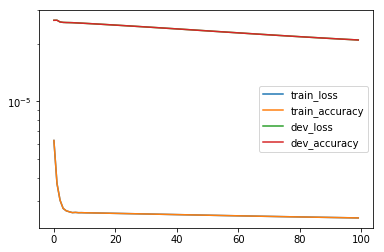

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_first_diff (Conv1D)    multiple                  2         
_________________________________________________________________
conv1_n_diff (Conv1D)        multiple                  10        
_________________________________________________________________
p_attention_1 (pAttention)   multiple                  3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None
[<tf.Variable 'micro_conv_cnn_1/conv1_first_diff/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
array([[[-1.0003932]],

       [[ 1.0006373]]], dtype=float32)>, <tf.Variable 'micro_conv_cnn_1/conv1_n_diff/kernel:0' shape=(10, 1, 1) dtype=float32, numpy=
array([[[-0.2026091 ]],

       [[-0.16887301]],

       [[-0.12978248]],

       [[-0.08834133]],

       [[-0.04705592]],

       [[-0.00713012]],



In [9]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = MicroConvCNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                hparams.neurons_unit, hparams.batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=100, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 10000, accuracy * 10000, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.yscale('log')
plt.show()

#trainer.save_model(model, optimizer, dataset_val, hparams, 'MicroConvCNN' + get_fields.replace(' ', '_'), stats=stats)
print(model.summary())
print(model.variables)
print(optimizer._lr)

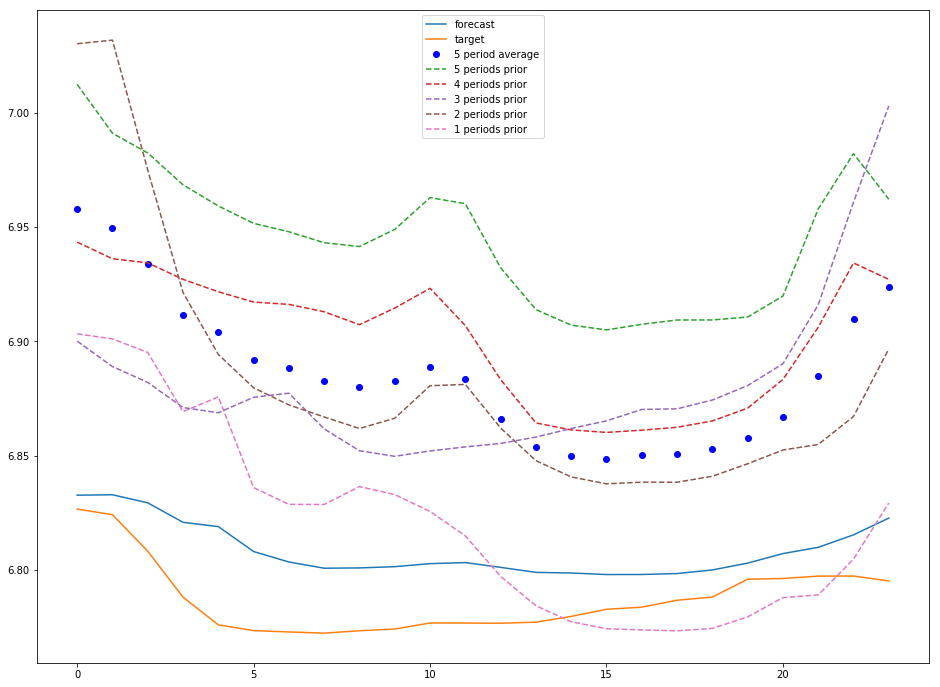

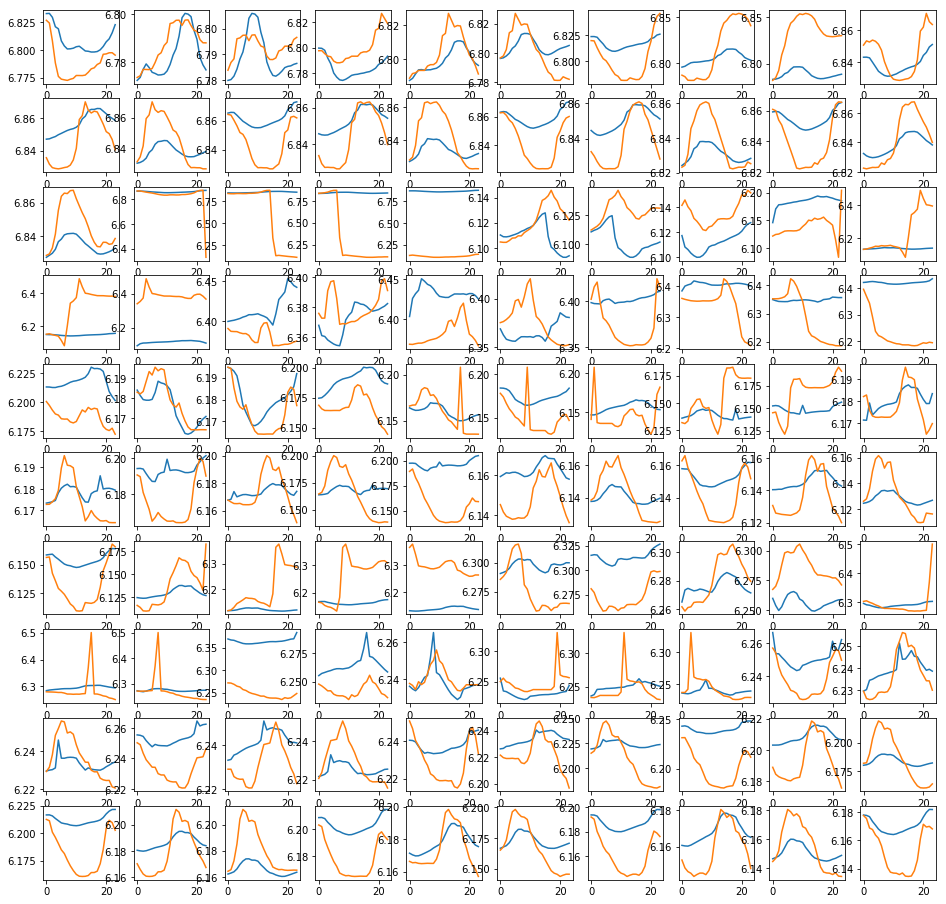

In [11]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 0

# Create forecast and rescale data
inp, target, mask, x_max = next(iter(dataset))
x_max = tf.expand_dims(x_max,-1)
forecast = model(inp, mask)
forecast *= x_max
target   *= x_max
inp      *= x_max
inp = tf.reshape(inp[:,-hparams.input_dim * hparams.out_seq_len:],
                 [hparams.batch_size, hparams.input_dim, hparams.out_seq_len, -1])
inp = tf.transpose(inp, [0,2,1,3])

# Plot target sequence
#print('Attention Weights: ', ['{:.1f}'.format(i * 100) for i in model.attn.w[TARGET_INDEX,0]])
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (hparams.input_dim-i))
plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

## Test Hyperparameters

In [13]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model_ = MicroConvCNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                       hparams.neurons_unit, hparams.batch_size)
    optimizer_ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model_, optimizer_, dataset, hparams, epochs = 5, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model_)
    stats.append(stat)

Learning Rate -4.0000 Loss 0.0262 Accuracy 0.0262 Time 3.1
Learning Rate -3.5000 Loss 0.0262 Accuracy 0.0262 Time 3.0
Learning Rate -3.0000 Loss 0.0263 Accuracy 0.0263 Time 3.0
Learning Rate -2.5000 Loss 0.0268 Accuracy 0.0268 Time 3.1
Learning Rate -2.0000 Loss 0.0290 Accuracy 0.0290 Time 3.1
Learning Rate -1.5000 Loss 0.0429 Accuracy 0.0429 Time 3.1
Learning Rate -1.0000 Loss 0.0294 Accuracy 0.0294 Time 3.2
Learning Rate -0.5000 Loss 0.9667 Accuracy 0.9667 Time 3.2


Learning Rate -3.5000 Loss 0.0254 Accuracy 0.0254 Time 32.2
Learning Rate -3.0000 Loss 0.0247 Accuracy 0.0247 Time 31.2
Learning Rate -2.5000 Loss 0.0254 Accuracy 0.0254 Time 31.5

## Test Model Accuracy

In [14]:
model_accuracy = []

Train Results
Total RSE Accuracy: 0.0309
Total MSE Accuracy: 0.0027
Test Results
Total RSE Accuracy: 0.0240
Total MSE Accuracy: 0.0021


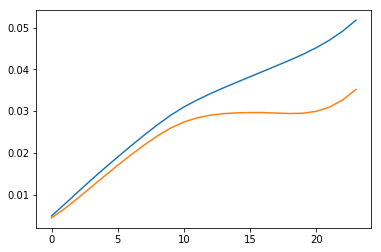

In [15]:
for name, dataset_eval in([['Train', dataset], ['Test', dataset_test]]):
    print(name + ' Results')
    total_accuracy = []
    x_variance = x_var(hparams, mode=get_fields)

    for i, (inp, target, mask, x_max) in enumerate(dataset_eval):
        forecast = model(inp, mask)

        accuracy = tf.squeeze(forecast - target) * x_max
        accuracy = accuracy ** 2 / x_variance
        accuracy = np.mean(accuracy, axis=0)

        total_accuracy.append(accuracy)

    model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))

    print('Total RSE Accuracy: %.4f' % np.mean(total_accuracy))
    print('Total MSE Accuracy: %.4f' % (np.mean(total_accuracy) * x_variance))
    plt.plot(np.mean(total_accuracy, axis=0))
plt.show()